# Problema 1


##Descripción
En este problema, se presenta un conjunto de datos que contiene información sobre el rendimiento académico de estudiantes universitarios, así como diversos factores que podrían influir en él. El objetivo es construir un modelo de regresión utilizando redes neuronales para predecir el índice de rendimiento académico de los estudiantes basado en las características proporcionadas.

##Dataset
https://www.kaggle.com/c/titanic/overview

El dataset proporcionado incluye las siguientes variables para cada estudiante:
* Hours Studied: El número total de horas dedicadas al estudio por cada estudiante.
* Previous Scores: Las puntuaciones obtenidas por los estudiantes en exámenes previos.
* Extracurricular Activities: Si el estudiante participa en actividades extracurriculares (Sí o No).
* Sleep Hours: El número promedio de horas de sueño que el estudiante tuvo por día.
* Sample Question Papers Practiced: El número de cuestionarios de muestra que el estudiante practicó.
Además, el dataset incluye la variable objetivo:
* Performance Index: Un índice que representa el rendimiento académico general de cada estudiante, redondeado al entero más cercano. Este índice varía de 10 a 100, donde valores más altos indican un mejor rendimiento.

##Objetivo
Utilizando el dataset proporcionado, el objetivo es construir un modelo de regresión utilizando redes neuronales que pueda predecir con precisión el índice de rendimiento académico de los estudiantes. Se debe entrenar y evaluar el modelo utilizando técnicas adecuadas de validación y métricas de evaluación de regresión.

##Funciones y librerías

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



In [39]:
#Función para realizar gráficos de línea
def graf_linea(df, fecha, valores_y1, *valores_y):
    plt.figure(figsize=(10, 4), facecolor='white')
    sns.set(style="darkgrid")
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", '#9a2ca0'
    ,'#000000','#7f7f7f','#bcbd22']

    valores = [valores_y1, *valores_y]

    for i, valor in enumerate(valores):
        plt.plot(df[fecha], df[valor], label=valor, color=colors[i])

    plt.title('Evolución de ' + ', '.join(valores))
    plt.legend(frameon=False)
    plt.xticks(rotation=90)

    # Configurar los ticks del eje x cada 5 años
    # plt.xticks(range(df[fecha].min(), df[fecha].max(), 5))

    plt.show()

#Función para gráficos de barras
def graf_barras(df,valores_x,valores_y):
    df = df.sort_values(valores_y, ascending=False)
    df.plot(kind='bar', x=valores_x, y=valores_y, color='#08306B', width=0.9,figsize=(10,5))
    plt.title(valores_y + ' vs ' + valores_x)
    plt.show()

#Función para gráficos de dispersión
def graf_dispersion(df, valores_x, valores_y):
    # Filtrar los valores NaN en las columnas de interés
    df_filtered = df[[valores_x, valores_y]].dropna()

    fig, ax = plt.subplots()
    df_filtered.plot(x=valores_x, y=valores_y, kind='scatter', ax=ax)
    ax.set_xlabel(valores_x)
    ax.set_ylabel(valores_y)
    ax.set_title('Gráfico de dispersión entre ' + valores_x + ' y ' + valores_y)
    plt.show()


# Función para gráficos de dispersión comparando entre series
def graf_dispersion_comparativa(df, locations, x_var, y_var, marker_size=10):
    plt.figure(figsize=(10, 3))  # Define el tamaño de la figura

    # Bucle para cada localización
    for loc in locations:
        # Filtrar los datos
        subset = df[df['Location'] == loc]

        # Convertir la columna de fecha si es necesario
        if pd.api.types.is_string_dtype(subset[x_var]):
            subset[x_var] = pd.to_datetime(subset[x_var])

        # Graficar
        plt.scatter(subset[x_var], subset[y_var], label=loc, s=marker_size)

    # Decorar el gráfico
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.title(f'Dispersión de {y_var} en diferentes localizaciones')
    plt.legend()
    plt.show()

#Función para gráficos de bigotes, 0 para un diseño compacto, 1 para un diseño más detallado
def bigote(df,columna,diseño=0):
    if diseño==0:
      plt.figure(figsize=(8, 0.2))  # Ajusta el ancho y la altura según tus preferencias
      sns.boxplot(data=df, x=columna, orient='h', color='#08306B')
      plt.xlabel(columna)
      plt.show()
    elif diseño==1:
      Q1 = df[columna].quantile(q=0.25)
      Q3 = df[columna].quantile(q=0.75)
      IQR = Q3 - Q1
      fig = plt.figure(figsize =(10, 7))
      plt.boxplot(df[columna], patch_artist=True, boxprops=dict(facecolor='#08306B'))
      plt.text(1.1, df[columna].median(), "Mediana: {:.1f}".format(df[columna].median()),fontsize=8)
      plt.text(1.1, df[columna].quantile(q=0.25), "Q1: {:.1f}".format(df[columna].quantile(q=0.25)),fontsize=8)
      plt.text(1.1, df[columna].quantile(q=0.75), "Q3: {:.1f}".format(df[columna].quantile(q=0.75)),fontsize=8)
      plt.text(0.85, df[columna].median(), "IQR: {:.1f}".format(IQR),fontsize=8)
      plt.xlabel(columna)

In [40]:
#Función para explorar las medidas principales de un df y su correlación
def explorar(df):
    # Filtrar las columnas numéricas
    columnas_numericas = df.select_dtypes(include='number').columns
    # Iterar sobre cada columna numérica y llamar a la función bigote
    for columna in columnas_numericas:
        histograma(df,columna)

def histograma(data, columna, estilo='darkgrid', facecolor='#1E1E1E', gridcolor='#2C2F33', textcolor='white', edgecolor='gray'):
    # Configuración del estilo de los gráficos
    sns.set(style=estilo)
    plt.rcParams['axes.facecolor'] = facecolor
    plt.rcParams['figure.facecolor'] = facecolor
    plt.rcParams['grid.color'] = gridcolor
    plt.rcParams['text.color'] = textcolor
    plt.rcParams['axes.labelcolor'] = textcolor
    plt.rcParams['xtick.color'] = textcolor
    plt.rcParams['ytick.color'] = textcolor
    plt.rcParams['axes.edgecolor'] = edgecolor

    # Crear un displot con un mapa de densidad de kernel (KDE)
    g = sns.displot(x=columna, data=data, palette='Set2', kind='kde', height=5, aspect=1.5, color="#007ACC")

    # Calcular estadísticas relevantes
    min_val = data[columna].min()
    max_val = data[columna].max()
    mean_val = data[columna].mean()
    std_dev = data[columna].std()
    cuartiles = data[columna].quantile([0.25, 0.5, 0.75])
    iqr = cuartiles[0.75] - cuartiles[0.25]
    lower_bound_iqr = cuartiles[0.25] - 1.5 * iqr
    upper_bound_iqr = cuartiles[0.75] + 1.5 * iqr

    # 3σ limits
    lower_bound_3std = mean_val - 3 * std_dev
    upper_bound_3std = mean_val + 3 * std_dev

    # Select more permissive bounds
    lower_bound = lower_bound_3std
    upper_bound = upper_bound_3std

    # Determine the method used
    method_used = "IQR" if (lower_bound == lower_bound_iqr and upper_bound == upper_bound_iqr) else "3σ"

    # Plot lines for the bounds
    plt.axvline(x=lower_bound, color='salmon', linestyle='--', linewidth=2)
    plt.axvline(x=upper_bound, color='salmon', linestyle='--', linewidth=2)
    plt.text(lower_bound, plt.gca().get_ylim()[1], f'Lower Bound ({method_used})', color='salmon', ha='right', va='top', rotation=90)
    plt.text(upper_bound, plt.gca().get_ylim()[1], f'Upper Bound ({method_used})', color='salmon', ha='left', va='top', rotation=90)

    # Plot line for the mean
    plt.axvline(x=mean_val, color="#007ACC", linestyle='-', linewidth=2)
    plt.text(mean_val + 0.1 * std_dev, plt.gca().get_ylim()[1] / 2, f'Mean: {mean_val:.2f}', color="#007ACC", ha='left', rotation=90)

    # Título del gráfico elevado para evitar superposición
    plt.gcf().suptitle(f'Histograma de {columna}', color=textcolor, y=1.05)  # Elevamos y ajustamos el color del título

    # Agregar líneas verticales y texto para los cuartiles con etiquetas Q1, Q2, Q3
    quartile_labels = ['Q1', 'Q2', 'Q3']
    for q, label in zip(cuartiles.index, quartile_labels):
        value = cuartiles[q]
        plt.axvline(x=value, color='#ffffff', linestyle='-', linewidth=1)
        plt.text(value, plt.gca().get_ylim()[1]*1.05, f'{label}', color='#ffffff', ha='center', va='top', rotation=0)

    # Añadir un cuadro de texto para resumir estadísticas
    stats_text = (f'Mean: {mean_val:.2f}\n'
                  f'Std Dev: {std_dev:.2f}\n'
                  f'Min: {min_val:.2f}\n'
                  f'Max: {max_val:.2f}\n'
                  f'Q1\n'
                  f'Q2 (Median)\n'
                  f'Q3\n'
                  f'Lower Bound ({method_used}): {lower_bound:.2f}\n'
                  f'Upper Bound ({method_used}): {upper_bound:.2f}')
    plt.gcf().text(0.95, 0.5, stats_text, fontsize=10, color=textcolor, ha='left', va='center')

    # Muestra el gráfico
    plt.show()

In [41]:
#Función para ver NaN de un df y su posibilidad de tratamiento
def analisis_nan(df):
    # Calcula la matriz de correlación
    correlation_matrix = df.corr(numeric_only=True)

    # Crea el nuevo DataFrame df_nan
    df_nan = pd.DataFrame(columns=['Columna', 'Max_Abs_Correlacion', 'Valor_Correlacion', 'Valores_NaN'])

    # Itera sobre las columnas y llena df_nan con los valores correspondientes
    for columna in correlation_matrix.columns:
        max_corr_columna = correlation_matrix[columna].drop(columna).abs().idxmax()
        max_corr_valor = correlation_matrix[columna][max_corr_columna]
        valores_nan = df[columna].isna().sum()
        df_nan = pd.concat([df_nan, pd.DataFrame({'Columna': [columna],
                                                  'Max_Abs_Correlacion': [max_corr_columna],
                                                  'Valor_Correlacion': [max_corr_valor],
                                                  'Valores_NaN': [valores_nan]})], ignore_index=True)

    return df_nan

## Preparación del entorno

Se obtienen los datos del repositorio TP1-AA2-GarciaValeri.

In [42]:
import os

REPO_NAME = "TP1-AA2-GarciaValeri"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/LaraV15/TP1-AA2-GarciaValeri.git
  os.chdir(REPO_NAME)

Establecer GPU por defecto en caso de estar disponible.

In [43]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Análisis exploratorio

In [44]:
# Cargamos el dataset
dataset = pd.read_csv("Student_Performance.csv")

# Dividimos el dataset en train y test (80% train, 20% test en este ejemplo)
train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)

# Imprimimos las primeras filas de los datasets para verificar
print("Train Dataset:")
train_df.head()

Train Dataset:


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
9254,5,49,No,7,5,36.0
1561,2,48,Yes,7,6,25.0
1670,2,81,No,7,2,59.0
6087,2,46,No,6,1,22.0
6669,8,47,No,9,0,40.0


In [45]:
print("Test Dataset:")
test_df.head()

Test Dataset:


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
6252,5,69,No,8,2,51.0
4684,2,46,Yes,4,8,20.0
1731,7,56,Yes,7,5,46.0
4742,6,42,Yes,8,5,28.0
4521,7,53,No,4,6,41.0


Inspeccionamos cada columna del dataset para entender su significado y valores posibles.

<ipython-input-3-9f6d9e56ba42>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.displot(x=columna, data=data, palette='Set2', kind='kde', height=5, aspect=1.5, color="#007ACC")


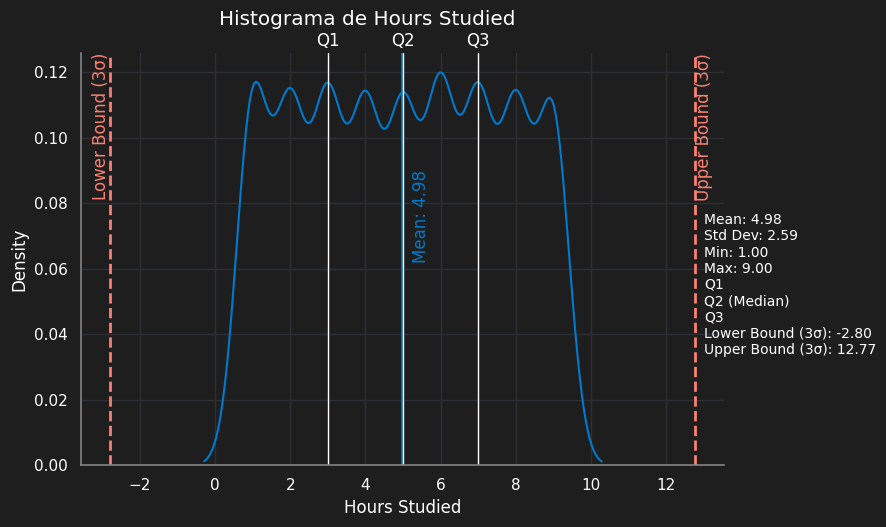

<ipython-input-3-9f6d9e56ba42>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.displot(x=columna, data=data, palette='Set2', kind='kde', height=5, aspect=1.5, color="#007ACC")


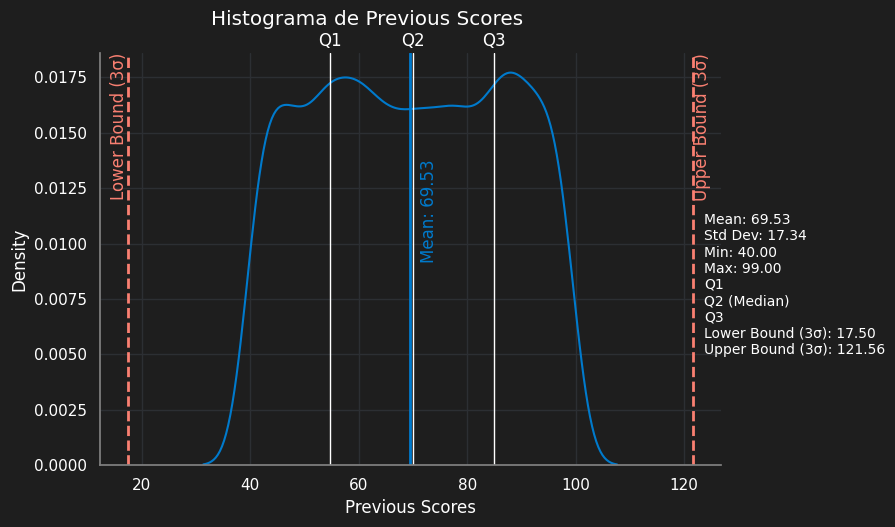

<ipython-input-3-9f6d9e56ba42>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.displot(x=columna, data=data, palette='Set2', kind='kde', height=5, aspect=1.5, color="#007ACC")


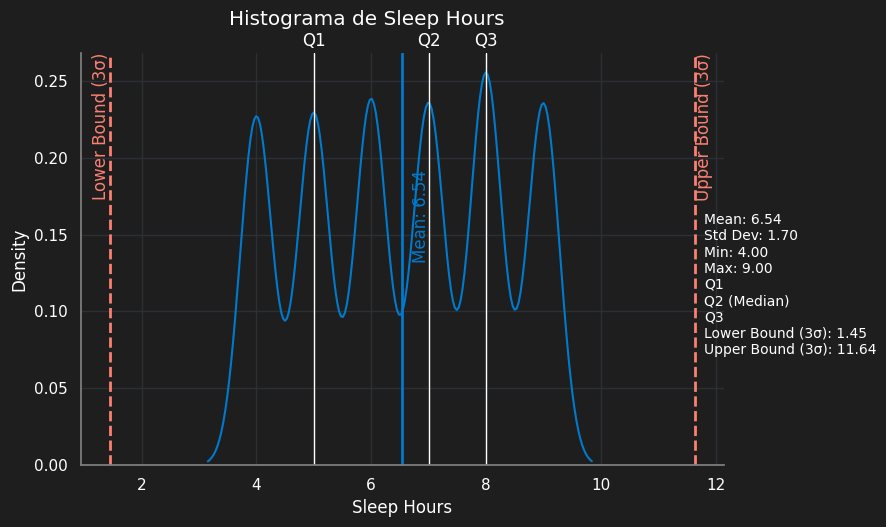

<ipython-input-3-9f6d9e56ba42>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.displot(x=columna, data=data, palette='Set2', kind='kde', height=5, aspect=1.5, color="#007ACC")


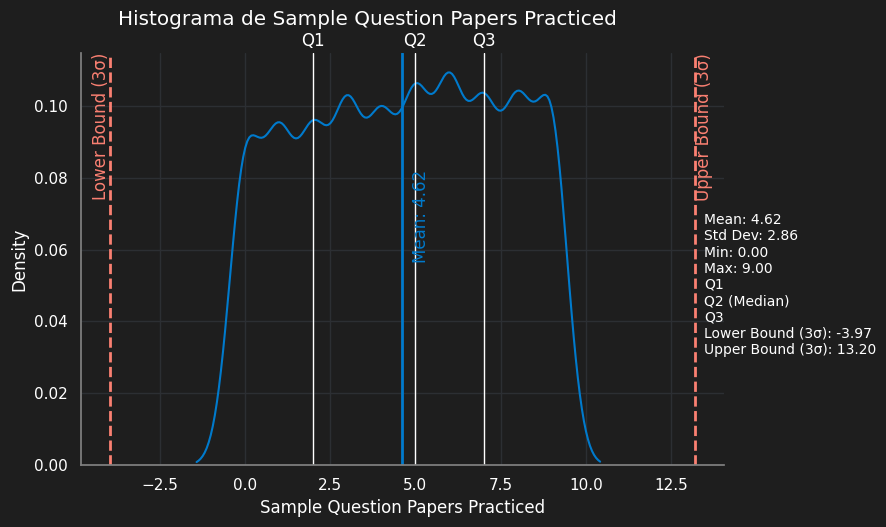

<ipython-input-3-9f6d9e56ba42>:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.displot(x=columna, data=data, palette='Set2', kind='kde', height=5, aspect=1.5, color="#007ACC")


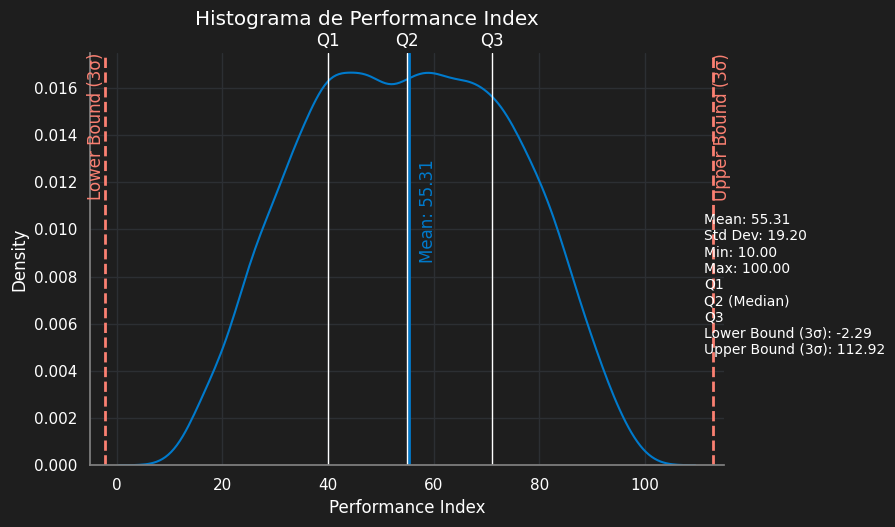

In [9]:
explorar(train_df)

In [46]:
analisis_nan(train_df)

<ipython-input-41-31fba78be25a>:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nan = pd.concat([df_nan, pd.DataFrame({'Columna': [columna],


,Columna,Max_Abs_Correlacion,Valor_Correlacion,Valores_NaN
0,Hours Studied,Performance Index,0.376255,0
1,Previous Scores,Performance Index,0.914718,0
2,Sleep Hours,Performance Index,0.044435,0
3,Sample Question Papers Practiced,Performance Index,0.043888,0
4,Performance Index,Previous Scores,0.914718,0


De la exploración anterior no se observan valores atípicos ni datos nulos.

Se considera que todas las columnas del dataset, excepto obviamente la target, son a priori relevantes para considerarlas en el entrenamiento del modelo.

A continuación se normalizan las variables explicativas y se aplica one-hot a la variable categórica 'Extracurricular Activities'.

In [52]:
# Defino un diccionario para definir el tipo de dato de cada columna
column_types = {
    "Hours Studied": "numeric",
    "Previous Scores": "numeric",
    "Extracurricular Activities": "categoric",
    "Sleep Hours": "numeric",
    "Sample Question Papers Practiced": "numeric"
}

# Diccionario para almacenar media y desvío estándar de las columnas numéricas.
# Útil para realizar predicciones en el futuro.
numeric_stats = {}

# Diccionario para almacenar los valores únicos de las columnas categóricas.
# Útil para realizar predicciones en el futuro.
categoric_values = {}

preprocessed_train_df = pd.DataFrame()
preprocessed_test_df = pd.DataFrame()

# Preprocesamiento del set de entrenamiento
for col in column_types.keys():
    if column_types[col] == "categoric":
        num_classes = train_df[col].nunique()
        # Obtengo el one-hot encoding de la columna
        one_hot = pd.get_dummies(train_df[col], prefix=col, dtype=np.float32)
        # Agrego las columnas al dataset preprocesado
        preprocessed_train_df = pd.concat([preprocessed_train_df, one_hot], axis=1)
        # Almaceno los valores únicos
        categoric_values[col] = train_df[col].unique()
    else:
        # Normalizo la columna
        preprocessed_train_df[col] = (train_df[col] - train_df[col].mean()) / train_df[col].std()
        # Almaceno media y desvío estándar
        numeric_stats[col] = {
            "mean": train_df[col].mean(),
            "std": train_df[col].std()
        }

# Agrergo la columna "Performance Index" al dataset preprocesado
preprocessed_train_df["Performance Index"] = train_df["Performance Index"]

# Muestro las primeras filas del dataset preprocesado
preprocessed_train_df.head()

,Hours Studied,Previous Scores,Extracurricular Activities_No,Extracurricular Activities_Yes,Sleep Hours,Sample Question Papers Practiced,Performance Index
9254,0.006455,-1.183770,1.0,0.0,0.269872,0.134033,36.0
1561,-1.149676,-1.241428,0.0,1.0,0.269872,0.483531,25.0
1670,-1.149676,0.661276,1.0,0.0,0.269872,-0.914463,59.0
6087,-1.149676,-1.356744,1.0,0.0,-0.318886,-1.263962,22.0
6669,1.162586,-1.299086,1.0,0.0,1.447386,-1.613461,40.0


In [53]:
# Preprocesamiento del set de test
for col in column_types.keys():
    if column_types[col] == "categoric":
        # Aplico el one-hot encoding usando las categorías del set de entrenamiento
        one_hot = pd.get_dummies(test_df[col], prefix=col, dtype=np.float32)
        preprocessed_test_df = pd.concat([preprocessed_test_df, one_hot], axis=1)

    else:
        # Normalizo usando la media y desvío estándar del set de entrenamiento
        mean = numeric_stats[col]["mean"]
        std = numeric_stats[col]["std"]
        preprocessed_test_df[col] = (test_df[col] - mean) / std

# Agregar la columna objetivo al set de test preprocesado
preprocessed_test_df["Performance Index"] = test_df["Performance Index"]

# Muestro las primeras filas del set de test preprocesado
preprocessed_test_df.head()


,Hours Studied,Previous Scores,Extracurricular Activities_No,Extracurricular Activities_Yes,Sleep Hours,Sample Question Papers Practiced,Performance Index
6252,0.006455,-0.030616,1.0,0.0,0.858629,-0.914463,51.0
4684,-1.149676,-1.356744,0.0,1.0,-1.496400,1.182529,20.0
1731,0.777209,-0.780166,0.0,1.0,0.269872,0.134033,46.0
4742,0.391832,-1.587374,0.0,1.0,0.858629,0.134033,28.0
4521,0.777209,-0.953140,1.0,0.0,-1.496400,0.483531,41.0


##Definición y entrenamiento del modelo con todas las características

In [54]:
# Defino los vectores X_test e y_test
y_test = preprocessed_test_df["Performance Index"].values.astype(np.float32)
X_test = preprocessed_test_df.drop("Performance Index", axis=1).values.astype(np.float32)
print(X_test.shape, y_test.shape)

(2000, 6) (2000,)


In [55]:
# Defino los vectores X_train, y_train, X_test e y_test
X_train = preprocessed_train_df.drop("Performance Index", axis=1).values.astype(np.float32)
y_train = preprocessed_train_df["Performance Index"].values.astype(np.float32)

print(X_train.shape, y_train.shape)

(8000, 6) (8000,)


Definimos un primer modelo y lo entrenamos

In [56]:
model_1 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model_1.summary()

model_1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

model_1.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 32)                  │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3139.9648 - mean_absolute_error: 52.7629 - val_loss: 1326.1256 - val_mean_absolute_error: 33.4110
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 635.0273 - mean_absolute_error: 20.5340 - val_loss: 22.3418 - val_mean_absolute_error: 3.7154
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.4030 - mean_absolute_error: 3.6795 - val_loss: 17.2236 - val_mean_absolute_error: 3.2645
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17.1450 - mean_absolute_error: 3.2332 - val_loss: 14.2097 - val_mean_absolute_error: 2.9694
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.1663 - mean_absolute_error: 2.9175 - val_loss: 11.8206 - val_mean_absolute_error: 2.7035
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.6295 - mean_absolute_error: 2.6382 - val_loss: 9.9723 - val_mean_absolute_error: 2.4859
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.5756 - mean_

In [57]:
# Evaluación del modelo con el conjunto de test
test_loss, test_mae = model_1.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2995 - mean_absolute_error: 1.6491
Test Loss (MSE): 4.235884666442871
Test MAE: 1.637329339981079


En primer lugar, a partir de los resultados obtenidos, podemos concluir que no hay subreajuste ya que los valoes de MSE y MAE son casi iguales tanto en entrenamiento como en test.

Un Error Absoluto Medio (MAE) alrededor de 1.6 sugiere que en promedio, el modelo predice con un error de 1.6 unidades respecto al valor real del índice. Esto no está mal consideranco que la escala de la variables es de 10 a 100, pero podemos intentar reducirlo más.



A continuación implementamos algunas mejoras al modelo. Agregamos más capas y dropout para reducir el sobreajuste.

In [14]:
model_2 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(1)
])

model_2.summary()

model_2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_2.fit(X_train, y_train, epochs=300,
          batch_size=16,
          callbacks=[early_stopping],
          validation_split=0.2)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2119.6060 - mean_absolute_error: 38.5050 - val_loss: 18.6136 - val_mean_absolute_error: 3.3919
Epoch 2/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 24.4280 - mean_absolute_error: 3.9573 - val_loss: 12.3505 - val_mean_absolute_error: 2.7828
Epoch 3/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 19.3447 - mean_absolute_error: 3.4933 - val_loss: 7.8570 - val_mean_absolute_error: 2.2372
Epoch 4/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.9805 - mean_absolute_error: 3.1458 - val_loss: 5.6373 - val_mean_absolute_error: 1.8894
Epoch 5/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 14.4550 - mean_absolute_error: 2.9622 - val_loss: 4.8497 - val_mean_absolute_error: 1.7550
Epoch 6/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.5441 - mean_absolute_error: 2.7667 - val_loss: 4.6663 - val_mean_absolute_error: 1.7226
Epoch 7/300
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 12.2609 - mean_absolut

Podemos observar que el modelo no mejora, las métricas dan peor que en el primer modelo. Entonces, decidimos quedarnos con ese modelo. Ya que además de que las métricas dan mejor, es un modelo más sencillo.

Esto nos lleva a preguntarnos, ¿todas las variables son relevantes para predecir índice de rendimiento académico de los estudiante o hay algunas que esten más relacionadas con la salida que otras? Para responder a esto analizamos la matriz de correlacción.

## Modelo con las características con mayor correlación con la salida

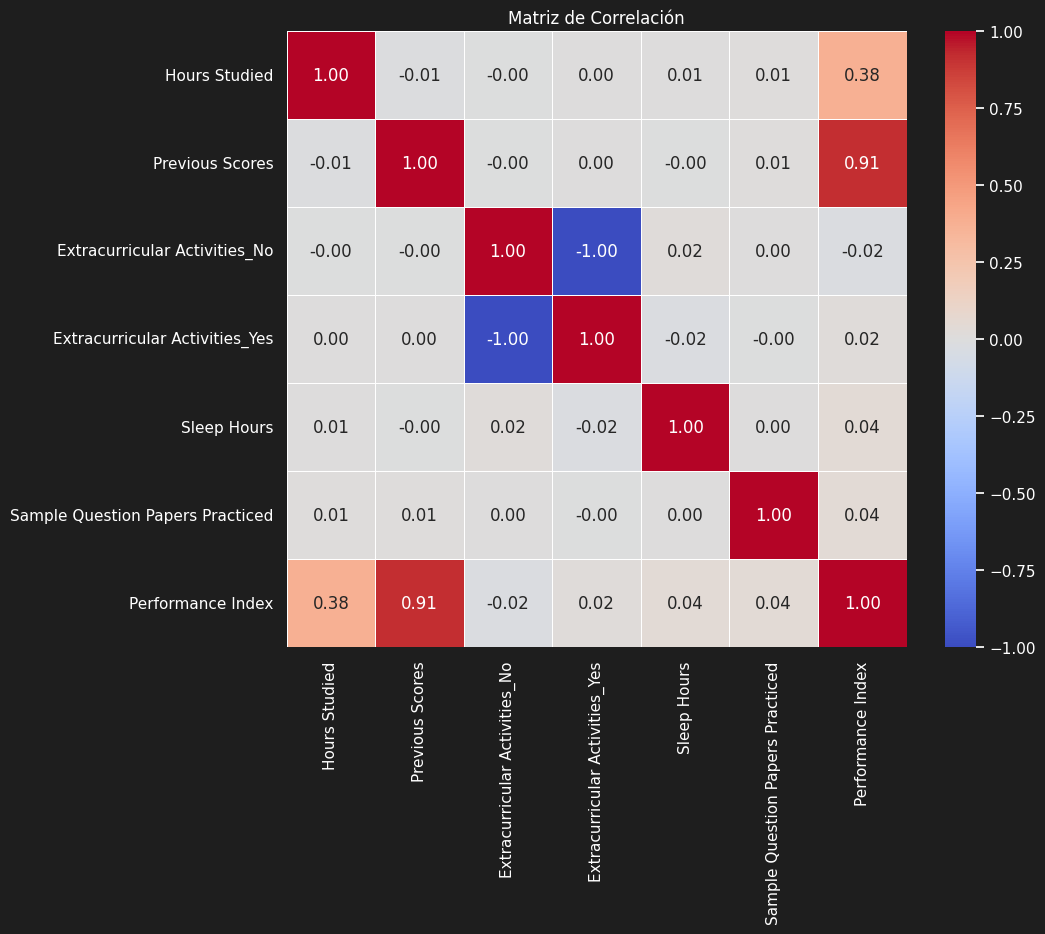

In [58]:
# Calculo la matriz de correlación del DataFrame de entrenamiento
correlation_matrix = preprocessed_train_df.corr()

# Visualizo la matriz de correlación con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

En este gráfico se puede ver que hay dos variables que estan mas relacionados con la variable target que son: 'Previous Scores' y 'Performance Index.

In [59]:
# Filtramos las correlaciones con respecto a la variable objetivo 'Performance Index'
target_corr = correlation_matrix["Performance Index"].drop("Performance Index")

# Obtenemos las dos características con mayor correlación absoluta
top_2_features = target_corr.abs().nlargest(2)

print("Las dos columnas con mayor correlación con 'Performance Index' son:")
print(top_2_features)


Las dos columnas con mayor correlación con 'Performance Index' son:
Previous Scores    0.914718
Hours Studied      0.376255
Name: Performance Index, dtype: float64


Decidimos entrar el modelo utilizando solo estas dos características.

In [61]:
# Filtramos solo las dos columnas más correlacionadas en los sets de entrenamiento y prueba
selected_features = ["Previous Scores", "Hours Studied"]

X_train_selected = preprocessed_train_df[selected_features].values.astype(np.float32)
X_test_selected = preprocessed_test_df[selected_features].values.astype(np.float32)
y_train = preprocessed_train_df["Performance Index"].values.astype(np.float32)
y_test = preprocessed_test_df["Performance Index"].values.astype(np.float32)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                     │ (None, 32)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3391.2405 - mean_absolute_error: 54.9833 - val_loss: 2749.9294 - val_mean_absolute_error: 48.7434
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2142.4053 - mean_absolute_error: 42.0416 - val_loss: 288.8058 - val_mean_absolute_error: 15.0099
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 144.9989 - mean_absolute_error: 10.1105 - val_loss: 49.4337 - val_mean_absolute_error: 5.7422
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 46.5178 - mean_absolute_error: 5.5605 - val_loss: 33.9235 - val_mean_absolute_error: 4.7187
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.3192 - mean_absolute_error: 4.6137 - val_loss: 22.9245 - val_mean_absolute_error: 3.8417
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 21.5340 - mean_absolute_error: 3.7179 - val_loss: 15.3394 - val_mean_absolute_error: 3.1106
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.9463 

In [63]:
# Definimos el modelo utilizando solo las dos características seleccionadas
model_3 = Sequential([
    Input(shape=(X_train_selected.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model_3.summary()

# Compilamos el modelo
model_3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Definimos el callback de Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Entrenamos el modelo
model_3.fit(X_train_selected, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                     │ (None, 32)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3174.7075 - mean_absolute_error: 53.0206 - val_loss: 1636.5054 - val_mean_absolute_error: 37.2314
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 938.8445 - mean_absolute_error: 26.3740 - val_loss: 63.4181 - val_mean_absolute_error: 6.4977
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.3157 - mean_absolute_error: 6.1468 - val_loss: 37.0392 - val_mean_absolute_error: 4.9255
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 35.3573 - mean_absolute_error: 4.8350 - val_loss: 24.0440 - val_mean_absolute_error: 3.9633
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22.7139 - mean_absolute_error: 3.8567 - val_loss: 15.6487 - val_mean_absolute_error: 3.1858
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 15.1105 - mean_absolute_error: 3.1185 - val_loss: 10.7384 - val_mean_absolute_error: 2.6159
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.5083 - mea

In [65]:
# Evaluamos el modelo con el conjunto de prueba
test_loss, test_mae = model_3.evaluate(X_test_selected, y_test)
print(f"Test Loss: {round(test_loss,2)}, Test MAE: {round(test_mae,2)}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5239 - mean_absolute_error: 1.8861
Test Loss: 5.34, Test MAE: 1.85


Los valores de pérdida y MAE para entrenamiento y validación son relativamente cercanos, lo que indica que el modelo se está generalizando bien y no está sobreajustando.

Por otro lado, Los valores de pérdida y MAE en el conjunto de test son ligeramente mayores que en los conjuntos de entrenamiento y validación, lo que nos sugiere que el modelo podria no estar generalizando tan bien en los datos de test como lo hace en el conjunto de validación.


Comparado con los modelos anteriores creemos que que la diferencia entre el MAE del modelo 1 y el modelo 3 son muy cercanas siendo la de menor valor la del modelo 1. Si se aprecia una diferencia mayor en el MSE, nuevamente siendo menor el del primer modelo.
Creemos que el primer modelo posee un mejor rendimiento, pero que al no haber grandes diferencias con el último modelo podemos utilizar dos características en vez de todas, para tener un modelo más simple.